In [1]:
import collections
import sys
sys.path.append("..")

import tqdm
import numpy as np
from IPython.display import SVG, HTML
from matplotlib import pyplot as plt
import tszip

import sc2ts
base_sc2_time = "2021-06-30"  # equivalent of day 0 in the sc2_ts file
sc2_ts = tszip.decompress(f"../results/upgma-full-md-30-mm-3-{base_sc2_time}.ts.tsz")

base_sc2_time = "2022-06-30"  # equivalent of day 0 in the sc2_ts file
sc2_ts = tszip.decompress(f"../results/upgma-mds-1000-md-30-mm-3-{base_sc2_time}.ts.tsz")


In [6]:
most_common_recombinant_mixes = {}
num_stored_recombinant_mixes = 3
mutations_per_node = np.zeros(sc2_ts.num_nodes, dtype=int)
reversions_per_node = np.zeros(sc2_ts.num_nodes, dtype=int)

for m in tqdm.tqdm(sc2_ts.mutations(), total=sc2_ts.num_mutations, desc="Checking mutations"):
    mutations_per_node[m.node] += 1
    if m.parent >= 0:
        mutation_parent = sc2_ts.mutation(m.parent)
        if mutation_parent.parent >= 0:
            mutation_parent_inherited_state = sc2_ts.mutation(mutation_parent.parent).derived_state
        else:
            mutation_parent_inherited_state = sc2_ts.site(m.site).ancestral_state
        if mutation_parent_inherited_state == m.derived_state:
            # this is a reversion
            reversions_per_node[m.node] += 1

Checking mutations: 100%|██████████| 1213193/1213193 [08:16<00:00, 2442.72it/s] 


In [7]:
times, counts = np.unique(sc2_ts.nodes_time[sc2_ts.samples()], return_counts=True)
times = times[counts > 5]  # Some times have few samples
data = {}

skipped_many_muts_recombinant = set()
skipped_child_reversions_recombinant = set()

for time in tqdm.tqdm(times, desc="Analysing sampling times"):
    ts = sc2_ts.simplify(sc2_ts.samples(time=time), keep_unary=True, filter_nodes=False)
    recombinants_in_ancestry = {u: set() for u in ts.samples()}
    first_edge = ts.edges_left.min()
    target_recombinants = set()
    for ed in ts.edge_diffs():
        if ed.interval.left == first_edge:
            continue  # Skip the first tree, for speed: recombinants arrive in intermediate trees anyway
        for e in ed.edges_in:
            u = e.child
            if (ts.node(u).flags & sc2ts.NODE_IS_RECOMBINANT) == 0:
                continue  # Only count recombination nodes
            if mutations_per_node[u] > 3:
                skipped_many_muts_recombinant.add(u)
                continue  # Recombinants with lots of mutatations are probably erroneous
            # Check if any of its immediate children have more than a single reversion
            children = np.unique(ts.edges_child[ts.edges_parent == u])
            if any(reversions_per_node[c] > 1 for c in children):
                skipped_child_reversions_recombinant.add(u)
                continue
            target_recombinants.add(u)
    for tree in ts.trees(sample_lists=True):
        for u in target_recombinants:
            for v in tree.samples(u):
                recombinants_in_ancestry[v].add(u)
    data[time] = np.bincount([len(s) for s in recombinants_in_ancestry.values()], minlength=50)
    most_common_recombinant_mixes[time] = collections.Counter(
        frozenset(v) for v in recombinants_in_ancestry.values()
    ).most_common(num_stored_recombinant_mixes)

Analysing sampling times:  37%|███▋      | 186/502 [07:22<12:32,  2.38s/it]


KeyboardInterrupt: 

In [8]:
import pandas as pd
df = pd.DataFrame(data).T
# Remove the zero padded columns
print(df.sum(axis=0))
df.drop(df.iloc[:, 14:], inplace=True, axis=1)
df

0     938867
1     183092
2       2762
3       2193
4        233
5        111
6         95
7         34
8         11
9          7
10         0
11         1
12         3
13         0
14         0
15         1
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
34         0
35         0
36         0
37         0
38         0
39         0
40         0
41         0
42         0
43         0
44         0
45         0
46         0
47         0
48         0
49         0
dtype: int64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0.0,1083,6844,12,40,2,0,1,0,0,0,0,0,1,0
1.0,1465,8989,69,68,2,0,3,2,0,0,0,0,0,0
2.0,1578,7184,98,67,4,0,0,1,0,0,0,0,0,0
3.0,696,4746,7,30,0,0,0,0,0,0,0,0,0,0
4.0,685,5464,6,24,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181.0,1873,13,1,0,0,0,0,0,0,0,0,0,0,0
182.0,1745,13,1,0,0,0,0,0,0,0,0,0,0,0
183.0,2563,21,2,0,0,0,0,0,0,0,0,0,0,0
184.0,4532,47,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df_sum = df.copy()
df_sum.iloc[:, 3] = df_sum.iloc[:, 3:].sum(axis=1)
df_sum.drop(df_sum.iloc[:, 4:], inplace=True, axis=1)
df_sum.rename(columns={0: "0", 1: "1", 2: "2", 3: "3+"}, inplace=True)
pro = df_sum.div(df_sum.sum(axis=1), axis=0)
pro

,0,1,2,3+
0.0,0.135663,0.857322,0.001503,0.005512
1.0,0.138234,0.848179,0.006511,0.007077
2.0,0.176668,0.804299,0.010972,0.008061
3.0,0.127030,0.866216,0.001278,0.005475
4.0,0.110841,0.884142,0.000971,0.004045
...,...,...,...,...
181.0,0.992581,0.006889,0.000530,0.000000
182.0,0.992041,0.007391,0.000569,0.000000
183.0,0.991106,0.008121,0.000773,0.000000
184.0,0.989736,0.010264,0.000000,0.000000


Text(0, 0.5, 'Daily proportion of samples')

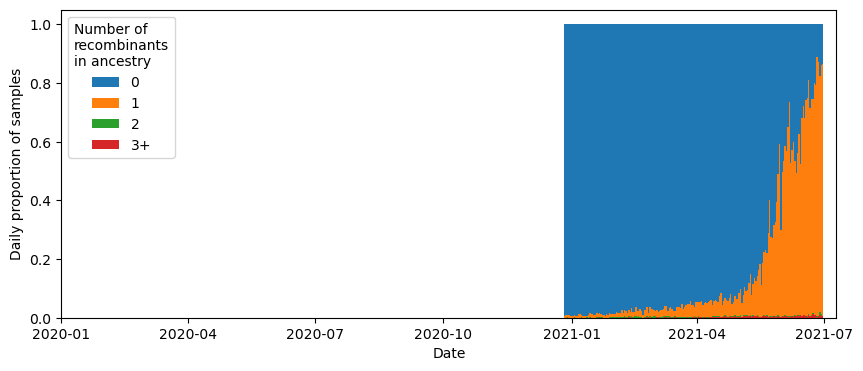

In [10]:
import datetime
sc2_date = datetime.datetime(*[int(x) for x in base_sc2_time.split("-")])
dates = [datetime.datetime(y, m, 1)  for y in (2020, 2021, 2022) for m in range(1, 13, 3) if (sc2_date-datetime.datetime(y, m, 1)).days > -2]

plt.figure(figsize=(10, 4))
p4 = plt.bar(pro.index, pro["0"],bottom=(pro["3+"] + pro["2"] + pro["1"]), width=1.0, label="0")
p3 = plt.bar(pro.index, pro["1"],bottom=(pro["3+"] + pro["2"]), width=1.0, label="1")
p2 = plt.bar(pro.index, pro["2"],bottom=pro["3+"], width=1.0, label="2")
p1 = plt.bar(pro.index, pro["3+"], width=1.0, label="3+")
plt.gca().legend(title="Number of\nrecombinants\nin ancestry")
plt.gca().invert_xaxis()
plt.xlabel(f"Date")
plt.xticks(
    ticks=[(sc2_date-d).days for d in dates],
    labels=[str(d)[:7] for d in dates],
)
plt.ylabel(f"Daily proportion of samples")


In [11]:
dates

[datetime.datetime(2020, 1, 1, 0, 0),
 datetime.datetime(2020, 4, 1, 0, 0),
 datetime.datetime(2020, 7, 1, 0, 0),
 datetime.datetime(2020, 10, 1, 0, 0),
 datetime.datetime(2021, 1, 1, 0, 0),
 datetime.datetime(2021, 4, 1, 0, 0),
 datetime.datetime(2021, 7, 1, 0, 0)]

In [12]:
focal_time = min(most_common_recombinant_mixes.keys())
print(
    f"At the focal sampling time ({focal_time}),",
    "the most common recombinant mixes are:",
)
for val, count in most_common_recombinant_mixes[focal_time]:
    print(
        val,
        count,
        f"({count/np.sum(data[focal_time]) * 100}% of all samples on that day)",
    )

At the focal sampling time (0.0), the most common recombinant mixes are:
frozenset({496613}) 6809 (85.29374921708632% of all samples on that day)
frozenset() 1083 (13.566328447951898% of all samples on that day)
frozenset({496613, 590229, 600902}) 39 (0.4885381435550545% of all samples on that day)


In [133]:
focal_time = 300
print(
    f"At the focal sampling time ({focal_time}),",
    "the most common recombinant mixes are:",
)
for val, count in most_common_recombinant_mixes[focal_time]:
    print(
        val,
        count,
        f"({count/np.sum(data[focal_time]) * 100}% of all samples on that day)",
    )

At the focal sampling time (300), the most common recombinant mixes are:
frozenset({235293, 229998}) 909 (90.9% of all samples on that day)
frozenset() 80 (8.0% of all samples on that day)
frozenset({229998}) 7 (0.7000000000000001% of all samples on that day)


In [2]:
info = sc2ts.TreeInfo(sc2_ts)


Classifying mutations: 100%|██████████| 1062072/1062072 [00:17<00:00, 61632.77it/s]


In [3]:
def report(*args, **kwargs):
    display(*info.node_report(*args, **kwargs))


,recombinant,direct,path_length,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions
0,172374,True,1,172373,Wales/ALDP-125C4D7/2021,XA,1,0,0,2021-02-06,12 days,0000,0,0,0,0,0
1,206466,True,3,206465,USA/TX-TCH-TCMC03017/2021,XB,1,0,0,2021-03-05,27 days,0000,2,0,0,0,0
2,251176,True,1,251175,USA/MA-CDC-LC0040918/2021,XC,1,2,1,2021-04-10,12 days,1000,8,2,0,0,0
3,573905,True,1,573904,Turkey/HSGM-F12594/2021,XD,1,1,1,2021-12-30,10 days,0000,1,0,0,6,5
4,582054,True,1,582053,Denmark/DCGC-323778/2022,XH,1,5,11,2022-01-06,18 days,0000,4,0,0,7,4
5,588841,True,1,588840,England/PHEC-YYNR51S/2022,XF,1,1,1,2022-01-12,21 days,0000,1,0,0,3,1
6,589269,True,1,589268,USA/AZ-ASPHL-0290/2022,XS,1,0,0,2022-01-13,19 days,1000,13,3,0,0,0
7,555388,False,8,609189,France/OCC-2201311067/2022,XZ,1,0,0,2022-01-31,11 days,1000,0,0,0,0,0
8,609881,True,1,609880,Denmark/DCGC-354715/2022,XG,1,9,18,2022-01-31,8 days,0000,1,0,0,7,0
9,611036,True,1,611035,Sweden/SUS0009442/2022,XAF,1,0,0,2022-02-01,15 days,0001,4,0,0,0,0


# Report for 400905

[{'Nextclade_pango': 'B.1.617.2',
  'clade': '21J (Delta)',
  'country': 'USA',
  'date': '2021-08-13',
  'date_submitted': '2021-08-20',
  'gisaid_epi_isl': 'EPI_ISL_3520736',
  'host': 'Human',
  'qc.frameShifts.status': 'good',
  'qc.missingData.status': 'good',
  'qc.mixedSites.status': 'good',
  'qc.stopCodons.status': 'good',
  'sc2ts_qc': {'num_masked_sites': 663,
   'original_base_composition': {'-': 41,
    'A': 8790,
    'C': 5373,
    'G': 5741,
    'N': 569,
    'T': 9389},
   'original_md5': 'e9b42657d972634e2bf39583ae9f0e29'},
  'strain': 'USA/NY-CDCBI-CRSP_HUK3WLMCEZNWRLUV/2021',
  'totalSubstitutions': 38.0}]

### Node data 

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,child_mutations,child_reversions,role,branch_length
0,400905,USA/NY-CDCBI-CRSP_HUK3WLMCEZNWRLUV/2021,B.1.617.2,1,0,0,2021-08-13,7 days,0000,0,0,0,0,0,Child,0.0
1,397124,USA/NY-NYCPHL-005523/2021,B.1.617.2,1,16,26,2021-08-10,16 days,0000,1,0,0,19,0,Parent,3.0


### Edges

id,left,right,parent,child,metadata
0,0,29904,397124,400905,


### Copying pattern

pos
ref
P0
C
mut


## Left path to root

### Closest recombinant: 235293

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,400905,USA/NY-CDCBI-CRSP_HUK3WLMCEZNWRLUV/2021,B.1.617.2,1,0,0,2021-08-13,7 days,0000,0,0,0,3.000000
1,397124,USA/NY-NYCPHL-005523/2021,B.1.617.2,1,16,26,2021-08-10,16 days,0000,1,0,0,8.777832
2,478461,Push 1 reversions,,1,2,28,2021-08-02,-18841 days,----,1,0,0,61.444824
3,353351,Overlap 1 mut 2 sibs,,1,63,181,2021-06-01,-18779 days,----,1,0,0,28.222656
4,305120,Push 2 reversions,,1,12,248,2021-05-04,-18751 days,----,3,0,0,24.117188
5,261856,Overlap 1 mut 3 sibs,,1,72,8455,2021-04-10,-18727 days,----,1,0,0,7.562500
6,253063,Push 1 reversions,,1,355,170396,2021-04-02,-18719 days,----,1,1,0,0.459375
7,261771,Push 1 reversions,,1,107,174649,2021-04-02,-18719 days,----,1,1,0,3.215625
8,242933,Added 2021-04-03,,1,1,174649,2021-03-30,-18716 days,----,0,0,0,3.200000
9,243149,Push 7 reversions,,1,6,177632,2021-03-26,-18712 days,----,14,0,0,7.000000


## Right path to root

### Closest recombinant: 235293

,node,strain,pango,parents,children,descendants,date,delay,qc,mutations,reversions,immediate_reversions,branch_length
0,400905,USA/NY-CDCBI-CRSP_HUK3WLMCEZNWRLUV/2021,B.1.617.2,1,0,0,2021-08-13,7 days,0000,0,0,0,3.000000
1,397124,USA/NY-NYCPHL-005523/2021,B.1.617.2,1,16,26,2021-08-10,16 days,0000,1,0,0,8.777832
2,478461,Push 1 reversions,,1,2,28,2021-08-02,-18841 days,----,1,0,0,61.444824
3,353351,Overlap 1 mut 2 sibs,,1,63,181,2021-06-01,-18779 days,----,1,0,0,28.222656
4,305120,Push 2 reversions,,1,12,248,2021-05-04,-18751 days,----,3,0,0,24.117188
5,261856,Overlap 1 mut 3 sibs,,1,72,8455,2021-04-10,-18727 days,----,1,0,0,7.562500
6,253063,Push 1 reversions,,1,355,170396,2021-04-02,-18719 days,----,1,1,0,0.459375
7,261771,Push 1 reversions,,1,107,174649,2021-04-02,-18719 days,----,1,1,0,3.215625
8,242933,Added 2021-04-03,,1,1,174649,2021-03-30,-18716 days,----,0,0,0,3.200000
9,243149,Push 7 reversions,,1,6,177632,2021-03-26,-18712 days,----,14,0,0,7.000000


### Children 
Node 400905 has 0 children. Showing top-10 by descendant count

""


## Mutation path

,site,node,descendants,inheritors,inherited_state,derived_state,is_reversion,is_immediate_reversion,is_transition,is_transversion,is_insertion,is_deletion,parent,num_parents,time,id,metadata
29,26750,397124,27,27,C,T,False,False,True,False,False,False,-1,0,324.000000,868062,{}
27,24865,478461,29,29,C,T,False,False,True,False,False,False,-1,0,332.777832,770554,{}
31,27430,353351,181,179,G,A,False,False,True,False,False,False,-1,0,394.222656,897907,{'type': 'overlap'}
42,29779,305120,248,244,G,T,False,False,False,True,False,False,-1,0,422.445312,1060289,{}
18,21465,305120,248,246,T,G,False,False,False,True,False,False,-1,0,422.445312,648157,{}
24,24197,305120,248,246,G,T,False,False,False,True,False,False,-1,0,422.445312,754359,{}
2,1048,261856,8433,8413,G,T,False,False,False,True,False,False,-1,0,446.562500,46795,{'type': 'overlap'}
35,28271,253063,169991,161928,A,-,True,False,False,False,False,True,954308,2,454.125000,954509,{}
9,9559,261771,174297,174118,T,C,True,False,True,False,False,False,327566,1,454.584375,327656,{}
6,7124,243149,177270,176542,C,T,False,False,True,False,False,False,-1,0,461.000000,259546,{}


In [9]:
tables = sc2_ts.dump_tables()

In [10]:
tables.sort()